# Lab 2 - Arturo Avalos

Getting the data:

In [23]:
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import mlflow
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score

In [24]:
from sklearn import datasets
data = datasets.load_iris(as_frame=True)
data = data.frame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [25]:
y = data['target']
X = data.drop('target', axis=1)

In [26]:
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Training

In [27]:
mlflow.set_tracking_uri('https://mlflow-server-525775795233.us-west2.run.app')
mlflow.set_experiment('lab5-GCP-iris-classification')

2025/04/15 15:08:21 INFO mlflow.tracking.fluent: Experiment with name 'lab5-GCP-iris-classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1744754901454, experiment_id='1', last_update_time=1744754901454, lifecycle_stage='active', name='lab5-GCP-iris-classification', tags={}>

### Descision Tree 

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depths = [3, 5, 7, 10, None]
criterions = ['gini', 'entropy']

for depth in max_depths:
    for criterion in criterions:
        with mlflow.start_run():
            mlflow.set_tags({"Model": "decision-tree", "Train Data": "80%"})
            
            mlflow.log_params({'max_depth': depth, 'criterion': criterion})
            
            dt = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
            dt.fit(X_train, y_train)
            y_pred = dt.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

2025/04/15 15:08:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run polite-wren-757 at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1/runs/52595df52c02492dbc080421a3c9ed1b.
2025/04/15 15:08:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1.
2025/04/15 15:08:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-mole-10 at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1/runs/ce6312ca0310441db57535bc9d3f7b11.
2025/04/15 15:08:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1.
2025/04/15 15:08:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run delicate-newt-11 at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1/runs/9f4507bc7c414c4ba55e55c904651506.
2025/04/15 15:08:33 INFO mlflow.tracking._tracking_service.client:

### Knn

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

n_neighbors_values = [3, 5, 7, 10, 15]
weights_options = ['uniform', 'distance']

for n_neighbors in n_neighbors_values:
    for weights in weights_options:
        with mlflow.start_run():
            mlflow.set_tags({"Model": "knn", "Train Data": "80%"})
            
            mlflow.log_params({'n_neighbors': n_neighbors, 'weights': weights})
            
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

2025/04/15 15:08:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-goat-182 at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1/runs/6f1388e5fd4b40a1974aa8fccfd0e37a.
2025/04/15 15:08:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1.
2025/04/15 15:08:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run carefree-ox-587 at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1/runs/3d7256764c3c4f24a9f6c59683c183bc.
2025/04/15 15:08:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1.
2025/04/15 15:08:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run aged-fox-620 at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1/runs/b3ddde834a5b4a37a7483b34b97ba489.
2025/04/15 15:08:51 INFO mlflow.tracking._tracking_service.client: 🧪 Vi

In [34]:
# Register the model with specific run ID
run_id = "c400db34608d42988951452fab846a3e"
experiment = mlflow.get_experiment_by_name("lab5-GCP-iris-classification")

# Get run details
run = mlflow.get_run(run_id)
model_type = run.data.tags.get("Model", "unknown")
accuracy = run.data.metrics.get("accuracy", 0)

print(f"Selected model: {model_type} with accuracy {accuracy:.4f}")
print(f"Run ID: {run_id}")

# Register the model in the MLflow Model Registry
model_name = "iris_classifier_best"
model_version = mlflow.register_model(
    f"runs:/{run_id}/model",
    model_name
)

print(f"Model registered as: {model_name} (version: {model_version.version})")


Selected model: knn with accuracy 1.0000
Run ID: c400db34608d42988951452fab846a3e


Successfully registered model 'iris_classifier_best'.
2025/04/15 15:17:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: iris_classifier_best, version 1


Model registered as: iris_classifier_best (version: 1)


Created version '1' of model 'iris_classifier_best'.


### Random Forest

### Feature selection

Feature Importances:
             Feature  Importance
2  petal length (cm)    0.466330
3   petal width (cm)    0.407388
0  sepal length (cm)    0.096623
1   sepal width (cm)    0.029659


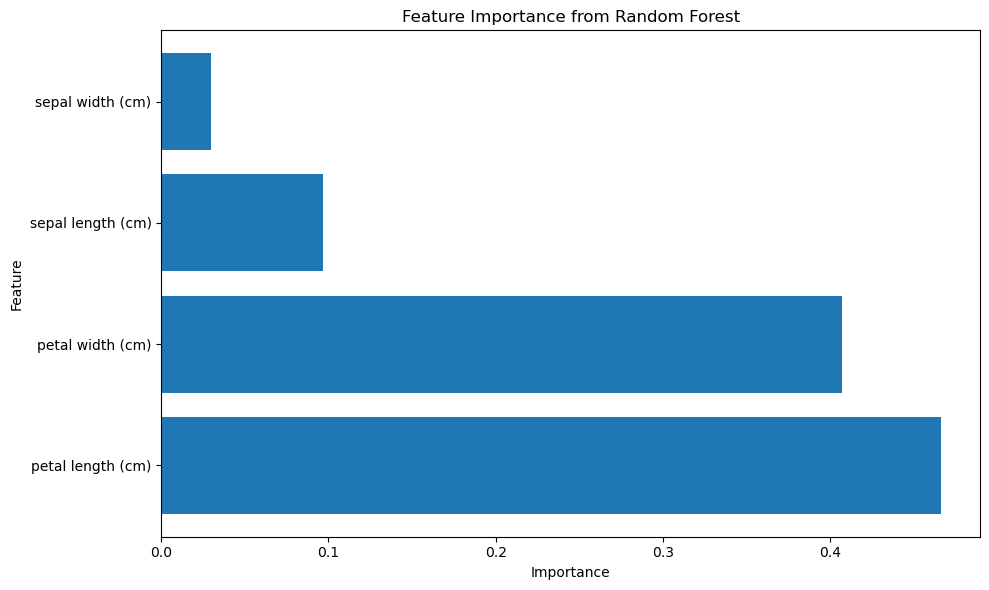

In [16]:
# # Get feature importance from the best Random Forest model
# #Actually all randoom forest model tested equally
# rf_best = RandomForestClassifier(
#     max_depth=10,  # Using a reasonable depth
#     criterion='entropy',
#     n_estimators=200,
#     random_state=42
# )
# rf_best.fit(X_train, y_train)

# # Get feature importances
# feature_importances = rf_best.feature_importances_

# # Create a DataFrame to display feature importances
# feature_names = X.columns
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importances
# })

# # Sort by importance
# importance_df = importance_df.sort_values('Importance', ascending=False)

# # Display the feature importances
# print("Feature Importances:")
# print(importance_df)

# # Visualize feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(importance_df['Feature'], importance_df['Importance'])
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance from Random Forest')
# plt.tight_layout()
# plt.show()

Checks out given our graph, let's now only use these two features.

In [18]:
red_X = X.drop(['sepal length (cm)','sepal width (cm)'], axis=1)


In [19]:
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(red_X, y, test_size=0.2, shuffle=True)

### Decison Tree v2

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depths = [3, 5, 7, 10, None]
criterions = ['gini', 'entropy']

for depth in max_depths:
    for criterion in criterions:
        with mlflow.start_run():
            mlflow.set_tags({"Model": "decision-tree-v2", "Train Data": "80%"})
            
            mlflow.log_params({'max_depth': depth, 'criterion': criterion})
            
            dt = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
            dt.fit(X_train, y_train)
            y_pred = dt.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

### KNN v2

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

n_neighbors_values = [3, 5, 7, 10, 15]
weights_options = ['uniform', 'distance']

for n_neighbors in n_neighbors_values:
    for weights in weights_options:
        with mlflow.start_run():
            mlflow.set_tags({"Model": "knn-v2", "Train Data": "80%"})
            
            mlflow.log_params({'n_neighbors': n_neighbors, 'weights': weights})
            
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

### Random Forest v2

In [23]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# max_depths = [3, 5, 7, 10, None]
# criterions = ['gini', 'entropy']
# n_estimators = [50, 100, 200]

# for depth in max_depths:
#     for criterion in criterions:
#         for n_estimator in n_estimators:
#             with mlflow.start_run():
#                 mlflow.set_tags({"Model": "random-forest-v2", "Train Data": "80%"})
                
#                 mlflow.log_params({
#                     'max_depth': depth, 
#                     'criterion': criterion,
#                     'n_estimators': n_estimator
#                 })
                
#                 rf = RandomForestClassifier(
#                     max_depth=depth, 
#                     criterion=criterion,
#                     n_estimators=n_estimator,
#                     random_state=42
#                 )
#                 rf.fit(X_train, y_train)
#                 y_pred = rf.predict(X_test)
#                 acc = accuracy_score(y_test, y_pred)
                
#                 mlflow.log_metric('accuracy', acc)
#             mlflow.end_run()

### Staging the best model

In [31]:
# Query MLflow to find the best model based on accuracy for Decision Trees and KNN
import mlflow
from mlflow.entities import ViewType

# Get all runs from the experiment
experiment = mlflow.get_experiment_by_name("lab5-GCP-iris-classification")

# The GCP MLflow server doesn't support 'OR' in filter_string
# Get decision tree runs
dt_runs = mlflow.search_runs(
    experiment_ids=experiment.experiment_id,
    filter_string="tags.Model = 'decision-tree'",
    run_view_type=ViewType.ACTIVE_ONLY,
    order_by=["metrics.accuracy DESC"]
)

# Get KNN runs
knn_runs = mlflow.search_runs(
    experiment_ids=experiment.experiment_id,
    filter_string="tags.Model = 'knn'",
    run_view_type=ViewType.ACTIVE_ONLY,
    order_by=["metrics.accuracy DESC"]
)

# Combine and sort the runs
runs = pd.concat([dt_runs, knn_runs]).sort_values("metrics.accuracy", ascending=False)

# Get the best run (first row in the sorted dataframe)
best_run = runs.iloc[0]
best_run_id = best_run.run_id
best_accuracy = best_run["metrics.accuracy"]
best_model_type = best_run["tags.Model"]

# Create parameter dictionary based on model type
best_model_params = {}
if best_model_type == "decision-tree":
    best_model_params = {
        'max_depth': best_run["params.max_depth"],
        'criterion': best_run["params.criterion"]
    }
elif best_model_type == "knn":
    best_model_params = {
        'n_neighbors': best_run["params.n_neighbors"],
        'weights': best_run["params.weights"]
    }

print(f"Best model type: {best_model_type}")
print(f"Best model run ID: {best_run_id}")
print(f"Best model accuracy: {best_accuracy:.4f}")
print(f"Best model parameters: {best_model_params}")

# Register the best model in the MLflow Model Registry
model_uri = f"runs:/{best_run_id}/model"
model_name = "iris_classifier"

# Register the model
model_details = mlflow.register_model(model_uri=model_uri, name=model_name)

# Transition the model to staging
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_details.version,
    stage="Staging"
)

print(f"Model {model_name} version {model_details.version} transitioned to Staging")


RestException: INVALID_PARAMETER_VALUE: Invalid clause(s) in filter string: 'OR'

### Running it on the test set

In [32]:
# Recreate the model with the best parameters
best_model = RandomForestClassifier(
    max_depth=None if best_model_params['max_depth'] == 'None' else int(best_model_params['max_depth']), 
    criterion=best_model_params['criterion'],
    n_estimators=int(best_model_params['n_estimators'])
)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Log the test metrics to MLflow
with mlflow.start_run(run_id=best_run_id):
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    # Log classification report
    from sklearn.metrics import classification_report
    # Get unique target names from the dataset
    target_names = [f"Class {i}" for i in sorted(y.unique())]
    report = classification_report(y_test, y_pred, target_names=target_names)
    mlflow.log_text(report, "test_classification_report.txt")
    print("\nClassification Report:")
    print(report)


Test set accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        12
     Class 1       1.00      1.00      1.00         8
     Class 2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### Logging best models information

In [36]:
top_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.max_depth,params.criterion,params.n_estimators,params.n_neighbors,params.weights,tags.Model,tags.mlflow.source.name,tags.mlflow.user,tags.Train Data,tags.mlflow.runName,tags.mlflow.source.type
0,ca8000ef00014850b73d5bfe6e873dea,4,FINISHED,/Users/arturoavalos/Documents/MSDS/4mod/mlops/...,2025-03-25 00:17:25.020000+00:00,2025-03-25 00:17:25.103000+00:00,1.0,None,entropy,200,None,None,random-forest-v2,/opt/homebrew/anaconda3/envs/mlops/lib/python3...,arturoavalos,80%,orderly-steed-643,LOCAL
1,0b0fdd87c62d4f3b915d14d486152877,4,FINISHED,/Users/arturoavalos/Documents/MSDS/4mod/mlops/...,2025-03-25 00:17:24.947000+00:00,2025-03-25 00:17:24.973000+00:00,1.0,None,entropy,50,None,None,random-forest-v2,/opt/homebrew/anaconda3/envs/mlops/lib/python3...,arturoavalos,80%,respected-whale-174,LOCAL
2,04f690032ab840b6b260eaa47e8dc065,4,FINISHED,/Users/arturoavalos/Documents/MSDS/4mod/mlops/...,2025-03-25 00:17:24.863000+00:00,2025-03-25 00:17:24.945000+00:00,1.0,None,gini,200,None,None,random-forest-v2,/opt/homebrew/anaconda3/envs/mlops/lib/python3...,arturoavalos,80%,learned-pug-207,LOCAL


In [32]:
# Get the top 3 runs from the DataFrame
top_runs = runs.iloc[:3]

for i, (_, run_row) in enumerate(top_runs.iterrows(), 1):
    run_id = run_row['run_id']
    
    print(f"\nBest Model #{i} (Run ID: {run_id}):")
    # Fix the formatting error by checking if the value is a string or number
    train_accuracy = run_row.get('metrics.train_accuracy', 'N/A')
    if isinstance(train_accuracy, (int, float)):
        print(f"Training Accuracy: {train_accuracy:.4f}")
    else:
        print(f"Training Accuracy: {train_accuracy}")
    
    # Fix the test accuracy display similarly
    test_accuracy = run_row.get('metrics.test_accuracy', 'N/A')
    if 'metrics.test_accuracy' in run_row:
        if isinstance(test_accuracy, (int, float)):
            print(f"Test Accuracy: {test_accuracy:.4f}")
        else:
            print(f"Test Accuracy: {test_accuracy}")
    else:
        print("Test Accuracy: Not yet evaluated")
    
    print("\nHyperparameters:")
    # Extract parameters from the DataFrame row
    param_columns = [col for col in run_row.index if col.startswith('params.')]
    for param_col in param_columns:
        param_name = param_col.replace('params.', '')
        param_value = run_row[param_col]
        if param_value is not None:  # Only print non-None parameters
            print(f"  {param_name}: {param_value}")
    
    # Log dataset information
    try:
        with mlflow.start_run(run_id=run_id, nested=True):
            mlflow.log_dict({
                "dataset_info": {
                    "training_set_shape": X_train.shape,
                    "test_set_shape": X_test.shape,
                    "training_samples": len(X_train),
                    "test_samples": len(X_test),
                    "features": list(X.columns),
                    "target_classes": sorted(y.unique().tolist())
                }
            }, "dataset_info.json")
    except Exception as e:
        print(f"Could not log dataset info for run {run_id}: {str(e)}")



Best Model #1 (Run ID: c400db34608d42988951452fab846a3e):
Training Accuracy: N/A
Test Accuracy: Not yet evaluated

Hyperparameters:
  weights: distance
  n_neighbors: 15


2025/04/15 15:12:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-eel-245 at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1/runs/c400db34608d42988951452fab846a3e.
2025/04/15 15:12:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server-525775795233.us-west2.run.app/#/experiments/1.


KeyboardInterrupt: 